In [1]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from matplotlib import cm # To import new color cards
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.svm import SVC


In [2]:
filename = 'C:/Users/laleh/Documents/Pythons/projet_blood/tests_images/data_1_13_classes.pkl'
df= pickle.load(open(filename, 'rb'))


In [3]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=123)




In [11]:
print(len(list(data_train.label.value_counts())))
print(len(list(data_test.label.value_counts())))

13
13


In [13]:
classes_names=["BNE_BNE",'eosinophil','IG_IG',"platelet","erythroblast","monocyte","basophil",
 "lymphocyte","IG_MY","IG_MMY","IG_PMY","BNE_SNE","BNE_NEUTROPHIL"]



train_data_generator=ImageDataGenerator(
preprocessing_function=preprocess_input,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=1.1,
horizontal_flip=True)

test_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32

data_train['out']=data_train.label.replace(classes_names,[0,1,2,3,4,5,6,7,8,9,10,11,12])
data_train['out']=data_train['out'].astype(str)
train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)
data_test['out']=data_test.label.replace(classes_names,[0,1,2,3,4,5,6,7,8,9,10,11,12])
data_test['out']=data_test['out'].astype(str)
test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

<ipython-input-13-4b46b8c2adc1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['out']=data_train.label.replace(classes_names,[0,1,2,3,4,5,6,7,8,9,10,11,12])
<ipython-input-13-4b46b8c2adc1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['out']=data_train['out'].astype(str)


Found 13673 validated image filenames belonging to 13 classes.
Found 3419 validated image filenames belonging to 13 classes.


<ipython-input-13-4b46b8c2adc1>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['out']=data_test.label.replace(classes_names,[0,1,2,3,4,5,6,7,8,9,10,11,12])
<ipython-input-13-4b46b8c2adc1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['out']=data_test['out'].astype(str)


In [14]:
from PIL import Image

def convert_image(X):
    X_img=[]
    for image in X:
        
        
             with Image.open(image) as im:

    
                    img = im.resize((224, 224))
                 
                    
                    a = np.asarray(img)
                    X_img.append(a) 
                    
                    
    return np.array(X_img)

# Load the images train
X_train_img= convert_image(data_train.path)
Y_train = data_train['out']

# Load the images test
X_test_img = convert_image(data_test.path)
Y_test = data_test['out']


# Modéle 

In [15]:

n_class=13



base_model=VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
    
    
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit_generator(generator=train_generator, 
                                epochs = 30,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )


intermediate_layer_model = Model( inputs=model.input, outputs=model.layers[2].output)
X_train_features = intermediate_layer_model.predict(preprocess_input(X_train_img))
X_test_features = intermediate_layer_model.predict(preprocess_input(X_test_img))

svm = SVC(C=111)


grid = svm.fit(X_train_features,  data_train["out"])

C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6

In [16]:
predictions_svm = svm.predict(X_test_features)

from sklearn.metrics import classification_report
print(classification_report(Y_test.values.astype(int),
predictions_svm.astype(int), target_names=classes_names))

                precision    recall  f1-score   support

       BNE_BNE       0.82      0.82      0.82       330
    eosinophil       0.99      1.00      1.00       627
         IG_IG       0.88      0.97      0.92        30
      platelet       1.00      1.00      1.00       449
  erythroblast       0.98      0.99      0.98       311
      monocyte       0.97      0.95      0.96       302
      basophil       0.99      0.99      0.99       222
    lymphocyte       0.98      0.97      0.97       236
         IG_MY       0.73      0.68      0.70       240
        IG_MMY       0.73      0.73      0.73       196
        IG_PMY       0.71      0.79      0.75       124
       BNE_SNE       0.85      0.86      0.86       345
BNE_NEUTROPHIL       1.00      1.00      1.00         7

      accuracy                           0.91      3419
     macro avg       0.89      0.90      0.90      3419
  weighted avg       0.91      0.91      0.91      3419



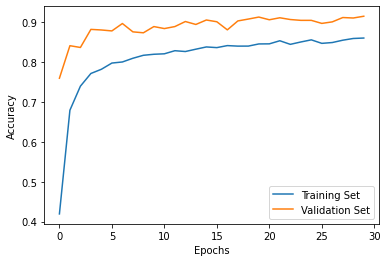

In [19]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(len(training_accuracy)), training_accuracy, label = 'Training Set')
plt.plot(np.arange(len(training_accuracy)), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [17]:
filename = 'svm_Transfer_Learning_13classes.pkl'
pickle.dump(svm, open(filename, 'wb'))

#svm= pickle.load(open(filename, 'rb'))

In [18]:
from tensorflow.keras.models import save_model, load_model
save_model(model,"model_Transfer_Learning_13classes")
#del model
#model=load_model("model_Transfer_Learning")

INFO:tensorflow:Assets written to: model_Transfer_Learning_13classes\assets
